In [13]:
from mmseg.datasets.pipelines import Compose
from mmcv import Config
from PIL import Image
import os
import matplotlib.pyplot as plt

import torch
import numpy as np
import tifffile 
from mmseg.models.utils.dacs_transforms import strong_transform, get_class_masks
import random
from mmseg.models import build_segmentor
from mmseg.models.builder import build_loss

In [14]:
loss_decode=dict(
                     type='CrossEntropyLoss',
                     use_sigmoid=False,
                     loss_weight=1.0)
loss = build_loss(loss_decode)

In [9]:
cfg = Config.fromfile('configs/mic/I3toLW4_mic_hrda_3D.py')

In [ ]:
cfg.uda

{'type': 'DACS',
 'source_only': False,
 'alpha': 0.999,
 'pseudo_threshold': 0.968,
 'pseudo_weight_ignore_top': 0,
 'pseudo_weight_ignore_bottom': 0,
 'imnet_feature_dist_lambda': 0.005,
 'imnet_feature_dist_classes': [6, 7, 11, 12, 13, 14, 15, 16, 17, 18],
 'imnet_feature_dist_scale_min_ratio': 0.75,
 'mix': 'class',
 'blur': True,
 'color_jitter_strength': 0.2,
 'color_jitter_probability': 0.2,
 'mask_mode': 'separatetrgaug',
 'mask_alpha': 'same',
 'mask_pseudo_threshold': 'same',
 'mask_lambda': 1,
 'mask_generator': {'type': 'block', 'mask_ratio': 0.7, 'mask_block_size': 64},
 'debug_img_interval': 1000,
 'print_grad_magnitude': False,
 'source': 'I3',
 'noise': 2}

In [81]:
# Load your config file
cfg = Config.fromfile('configs/_base_/datasets/uda_I3_to_LW4_3D.py')

# Build pipeline
pipeline = Compose(cfg.data.train.source.pipeline)

In [82]:
means = torch.tensor(cfg.img_norm_cfg.mean)
stds = torch.tensor(cfg.img_norm_cfg.std)

In [83]:
data_target = dict(
    img_info=dict(filename='images/patch_0057.tif'),
    ann_info=dict(seg_map='labels/patch_0057.tif'),
    img_prefix='data/LW4/patch_dataset',
    seg_prefix='data/LW4/patch_dataset',
    pseudo_label_prefix='data/LW4/patch_dataset',  # <--- Add this
    pseudo_label='sam/patch_0057.tif',                              # <--- And this
    seg_fields=[],
    sam_fields=[]
)

# Apply pipeline
processed_target = pipeline(data_target)

In [84]:
img_target = processed_target["img"].data
mask_target = processed_target["gt_semantic_seg"].data
sam_target = processed_target["sam_pseudo_label"].data

In [85]:
img_target.shape

torch.Size([1, 1, 40, 128, 128])

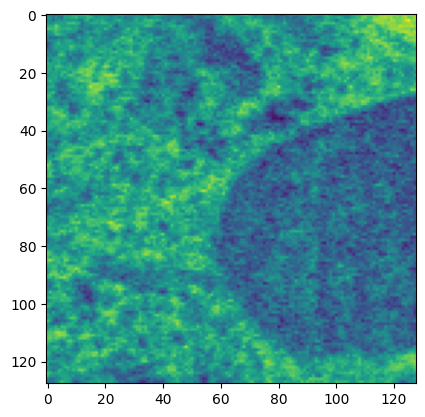

In [86]:
plt.imshow(img_target.squeeze()[0])

In [119]:
# Load a sample
data = dict(
    img_info=dict(filename='images/patch_0000.tif'),
    ann_info=dict(seg_map='labels/patch_0000.tif'),
    img_prefix='data/I3/patch_dataset',
    seg_prefix='data/I3/patch_dataset',
    pseudo_label_prefix='data/I3/patch_dataset',  # <--- Add this
    pseudo_label='sam/patch_0000.tif',                              # <--- And this
    seg_fields=[],
    sam_fields=[]
)

# Apply pipeline
processed = pipeline(data)

In [120]:
processed['gt_semantic_seg'].data.shape

torch.Size([1, 40, 128, 128])

In [134]:
img = processed['img'].data
img = (img * stds) + means # denormalize

mask = processed['gt_semantic_seg'].data

sam = processed["sam_pseudo_label"].data

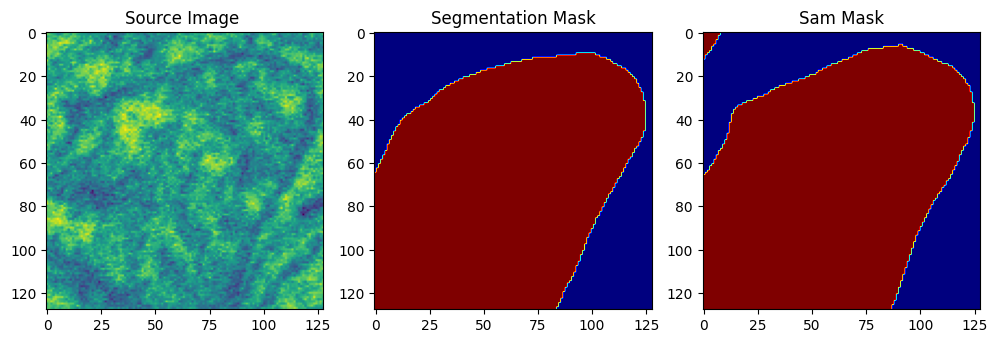

In [124]:


img = processed['img'].data.squeeze().numpy() 
img = (img * cfg.img_norm_cfg['std']) + cfg.img_norm_cfg['mean']  # denormalize
img = img.astype(np.uint8)

mask = processed['gt_semantic_seg'].data.squeeze().numpy()

sam = processed["sam_pseudo_label"].data.squeeze().numpy()

# Plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(img[0])
plt.title("Source Image ")


plt.subplot(1, 3, 2)
plt.imshow(mask[0], cmap='jet')  
plt.title("Segmentation Mask")


plt.subplot(1, 3, 3)
plt.imshow(sam[0], cmap='jet')  
plt.title("Sam Mask")


plt.tight_layout()
plt.show()

In [125]:
processed['img'].data.shape

torch.Size([1, 1, 40, 128, 128])

In [126]:
mask = processed['gt_semantic_seg'].data

In [127]:
mix_masks = get_class_masks(mask,True)

In [128]:
strong_parameters = {
            'mix': None,
            'color_jitter': random.uniform(0, 1),
            'color_jitter_s': 0.25,
            'color_jitter_p': 0.2,
            'blur': random.uniform(0, 1) ,
            'mean': means.unsqueeze(0),  # assume same normalization
            'std': stds.unsqueeze(0)
        }

In [129]:
mask.shape

torch.Size([1, 40, 128, 128])

In [130]:
img_target.shape

torch.Size([1, 1, 40, 128, 128])

In [136]:
torch.stack((img, img_target),dim=1).shape

torch.Size([1, 2, 1, 40, 128, 128])

In [137]:
strong_parameters['mix'] = mix_masks[0]
mixed_img, mixed_lbl = strong_transform(strong_parameters, data=torch.stack((img.squeeze(), img_target.squeeze())),  #ici source_img et target_img
                                                target=torch.stack((mask.squeeze(), mask_target.squeeze())))

In [138]:
mixed_img.shape

torch.Size([1, 1, 40, 128, 128])

In [139]:
tifffile.imwrite("./mixed_img.tif",mixed_img.squeeze().numpy().astype(np.uint8))

In [141]:
tifffile.imwrite("./mask.tif",mask.squeeze().numpy().astype(np.uint8))

In [ ]:
tifffile.imwrite("./img_target.tif",img_target.squeeze().numpy().astype(np.uint8))

In [72]:
img_target.dtype

torch.float32

In [80]:
img_target[0]

tensor([[[[-0.2856, -0.2513, -0.3712,  ..., -0.6452, -0.5253, -0.4739],
          [-0.1999, -0.1486, -0.2684,  ..., -0.6794, -0.9363, -0.4911],
          [-0.5767, -0.1828, -0.0287,  ..., -0.5424, -0.2342, -0.2171],
          ...,
          [-0.5082, -0.7650, -0.3027,  ..., -0.3027, -0.5938, -0.8164],
          [-0.8849, -0.4054, -0.0801,  ..., -0.1143, -0.1657, -0.1657],
          [-0.2856, -0.1999, -0.2513,  ..., -0.4911, -0.1828, -0.1314]],

         [[-0.0287,  0.0912,  0.2111,  ..., -0.5767, -0.6965, -0.5082],
          [-0.0629, -0.1143,  0.0227,  ..., -0.7822, -0.6965, -0.4568],
          [-0.1999,  0.0398,  0.0398,  ..., -0.6794, -0.6623, -0.3541],
          ...,
          [-0.3541, -0.3541, -0.3027,  ..., -0.3198, -0.2684, -0.4739],
          [-0.3198, -0.4226, -0.2856,  ..., -0.1999, -0.2171, -0.4739],
          [-0.3369, -0.3883, -0.3541,  ..., -0.2684, -0.3198, -0.4397]],

         [[-0.0629, -0.0629, -0.0801,  ..., -0.5253, -0.4739, -0.4226],
          [ 0.0912,  0.0912,  